In [19]:
import os
import pickle
import hashlib
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [20]:
## ********** data preprocessing functions **********

def clean_data(X):
  features_names = list(X)
  return X, features_names

def clean_metadata(meta_df):
  new_index = np.array(meta_df.index)
  k = 0
  for i, row in meta_df.iterrows():
    if row['Geography'] == 'Fiji':
      new_index[k] = i + '_profiled_Metaphlan3'
    elif row['Geography'] == 'Nunavik':
      new_index[k] = 'X' + i
    k += 1
  meta_df = meta_df.set_index(new_index)
  meta_df.columns = ['Age', 'Community', 'Sex', 'SampleIDC', 'Region', 'Lifestyle', 'Geography', 'Coast', 'Community size']
  print('available metadata:', list(meta_df))
  return meta_df

def preprocess_data(X, metadata):
  # assert that all samples are described in the metadata :
  y = [] #prepare labels list 
  for sample_name in X.index:
      if sample_name in metadata.index:
          # get sample metadata and add the corresponding label in y
          diet = metadata.loc[sample_name, 'Lifestyle']
          y.append(diet)
      else:
          # if sample not described in metadata : remove it from data matrix
          X = X.drop(sample_name)
  print('classes in y:', list(dict.fromkeys(y)))
  features_names = list(X)
  y = np.array(y)
  return X, y

def get_hash(e):
  # returns a hash value for a dataframe
  # used to ensure that the data is the same than in the original experiment run
  # idea from https://death.andgravity.com/stable-hashing
  assert isinstance(e, pd.DataFrame)
  json_dump = e.to_json(orient='split', date_format='epoch', double_precision=10, force_ascii=True, date_unit='ms', lines=False, index=True, indent=None)
  return hashlib.md5(json_dump.encode('utf-8')).digest().hex()

In [21]:
## ********** machine learning utils functions **********

dir = ''
splits_subdirectory = os.path.join(dir, 'splits')
results_subdirectory = os.path.join(dir, 'grid_search_results')

def generate_splits(X, y, n_splits, test_size, seed, dataset_name):
  if not os.path.exists(splits_subdirectory):
    os.makedirs(splits_subdirectory)
  for id in range(n_splits):
    random_state = seed + id
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    np.savez(os.path.join(splits_subdirectory, dataset_name+'_split_'+str(id)), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    print('split {} saved in {}'.format(id, os.path.join(splits_subdirectory, dataset_name+'_split_'+str(id))))

def grid_search_on_split(split_id, classifier, hyperparameters_grid, dataset_name):
  X_train, X_test, y_train, y_test = load_split(split_id, dataset_name)
  grid = GridSearchCV(estimator=classifier, param_grid=hyperparameters_grid, verbose=20, n_jobs=4)
  grid_result = grid.fit(X_train, y_train)
  print('grid-Search done!\n')
  best_params = grid_result.best_params_
  save_best_params(best_params, split_id, dataset_name)
  print('best params:', best_params)
  results = pd.DataFrame(grid_result.cv_results_) # convert GS results to a pandas dataframe
  save_grid_search_results(results, split_id, dataset_name)

def load_split(split_id, dataset_name):
  split_filename = os.path.join(splits_subdirectory, dataset_name+'_split_{}.npz'.format(split_id))
  split = np.load(split_filename)
  X_train, X_test = split['X_train'], split['X_test']
  y_train, y_test = split['y_train'], split['y_test']
  return X_train, X_test, y_train, y_test

def clean_splits_files(n_splits, dataset_name):
  for split_id in range(n_splits):
    split_filename = os.path.join(splits_subdirectory, dataset_name+'_split_{}.npz'.format(split_id))
    os.remove(split_filename)
  os.rmdir(splits_subdirectory)

def save_best_params(best_params, split_id, dataset_name):
  save_params_path = os.path.join(results_subdirectory, dataset_name+'_best_params_{}.pkl'.format(split_id))
  if not os.path.exists(results_subdirectory):
    os.makedirs(results_subdirectory)
  with open(save_params_path, 'wb') as f:
    pickle.dump(best_params, f)
  print('grid search best parameters for split {} saved in {}'.format(split_id, save_params_path))  

def load_best_params(split_id, dataset_name):
  best_params_filename = os.path.join(results_subdirectory, '{}_best_params_{}.pkl'.format(dataset_name, split_id))
  with open(best_params_filename, "rb") as f:
    best_params = pickle.load(f)
  return best_params

def save_grid_search_results(results, split_id, dataset_name):
  save_result_path = os.path.join(results_subdirectory, '{}_results_{}.csv'.format(dataset_name, split_id))
  if not os.path.exists(results_subdirectory):
    os.makedirs(results_subdirectory)
  results.to_csv(save_result_path)
  print('grid search results for split {} saved in {}.csv'.format(split_id, save_result_path))  

def load_grid_search_results(split_id, dataset_name):
  results_filename = os.path.join(results_subdirectory,'{}_results_{}.csv'.format(dataset_name, split_id))
  best_params = pd.read_csv(results_filename)
  return best_params

In [17]:
## ********** results vizualisation functions **********

def evaluate_predictions(y_test, pred):
  print('random_forest accuracy: ', round(accuracy_score(y_test, pred), 3))
  print('random_forest balanced_accuracy_score: ', round(balanced_accuracy_score(y_test, pred), 3))
  print('random_forest matthews_correlation coefficient: ', round(matthews_corrcoef(y_test, pred), 3))
  conf_labels = ['Westernized', 'Nunavik', 'Non Westernized']
  conf = confusion_matrix(y_test, pred, labels=conf_labels)
  confusion = conf/conf.sum()
  print('\n\n      # random forest confusion matrix :')
  print('                                              predicted values')
  print('                                  {}    |      {}     |  {}  | '.format(conf_labels[0], conf_labels[1], conf_labels[2]))
  print('                                ---------------------------------------------------------')
  print('   true     {}       |      {:.4f}      |      {:.4f}      |      {:.4f}       |'.format('Westernized', confusion[0,0], confusion[0,1], confusion[0,2]))
  print('  values                        ---------------------------------------------------------')
  print('            {}           |      {:.4f}      |      {:.4f}      |      {:.4f}       |'.format('Nunavik', confusion[1,0], confusion[1,1], confusion[1,2]))
  print('                                ---------------------------------------------------------')
  print('            {}   |      {:.4f}      |      {:.4f}      |      {:.4f}       |'.format('Non Westernized', confusion[2,0], confusion[2,1], confusion[2,2]))
  print('                                ---------------------------------------------------------')

def display_top_features(all_feature_importance_df, n_top_feat):
  all_feature_importance_dict = {feat: list(all_feature_importance_df[feat]) for feat in list(all_feature_importance_df)}
  #result_avg_importance = {features_names[i] : sum(all_features_importance[i])/len(all_features_importance[i]) for i in range(len(features_names))}
  #result_sorted = {k: v for k, v in sorted(result_avg_importance.items(), key=lambda item: item[1], reverse=True)}
  result_median_importance = {feat_name : statistics.median(all_feature_importance_dict[feat_name]) for feat_name in all_feature_importance_dict}
  result_average_importance = {feat_name : statistics.mean(all_feature_importance_dict[feat_name]) for feat_name in all_feature_importance_dict}
  result_pstdev_importance = {feat_name : statistics.pstdev(all_feature_importance_dict[feat_name]) for feat_name in all_feature_importance_dict}
  result_sorted = {k: v for k, v in sorted(result_median_importance.items(), key=lambda item: item[1], reverse=True)}
  rank = 0
  box_plot_dict = {'Feature name': [], 'Median Gini importance': []}
  print('  rank    feature {:55s}     '.format(''), 'median importance      average      standard-deviation')
  for k in result_sorted:
    rank += 1
    if rank <= n_top_feat:
      display_line = '  {:3d}     {:65s}         {:6.6f}          {:6.6f}         {:6.6f}'.format(rank, k, result_sorted[k], result_average_importance[k], result_pstdev_importance[k])
      print(display_line)
      box_plot_dict['Feature name'] = box_plot_dict['Feature name'] + [' ({}) {}'.format(k,str(rank))]*len(all_feature_importance_dict[k])
      box_plot_dict['Median Gini importance'] = box_plot_dict['Median Gini importance'] + all_feature_importance_dict[k]
  return pd.DataFrame(box_plot_dict)

In [23]:
## ********** running experiments **********

## ***** load data and metadata *****
data_filename = 'especes_metaphlan3.csv'
dataset_name = 'species'

X = pd.read_csv(data_filename, index_col=0)
X, features_names = clean_data(X)
# ensure that the data file is the same than in original experiment run :
assert get_hash(X) == '76db802436148af02fdc9d5ed48d7e5d'

meta_filename = 'Metadata_samples_all_controls_2020-09-02_V6.csv'
meta_df = pd.read_csv(meta_filename, sep=';', index_col=0, encoding_errors='replace')
# ensure that the metadata file is the same than in original experiment run :
assert get_hash(meta_df) == '53c67bf4e333301df1e90cddea472ef8'
metadata = clean_metadata(meta_df)
#print(metadata.head())

print('classes:', list(dict.fromkeys(metadata['Lifestyle'])))

X, y = preprocess_data(X, metadata)

print('# of samples:', X.shape[0])
print('# of features:', X.shape[1])
assert np.array_equal(X.shape[0], len(y))

## ***** generate splits of the data matrix *****
n_splits = 100
test_size = 0.3
seed = 1

splits_hashcode = generate_splits(X, y, n_splits, test_size, seed, dataset_name)

## ***** grid search tuning on splits *****
random_forest_n_estims = [1, 10, 100, 1000]
random_forest_param_grid = {'n_estimators' : random_forest_n_estims}
for split_id in range(n_splits):
  classifier = RandomForestClassifier(random_state=1)
  grid_search_on_split(split_id, classifier, random_forest_param_grid, dataset_name)

all_pred, all_y_test = [], []
sum_imp = []

for split_id in range(n_splits):
  print('split', split_id)
  X_train, X_test, y_train, y_test = load_split(split_id, dataset_name)
  classifier = RandomForestClassifier(random_state=1) #define classifier
  best_params = load_best_params(split_id, dataset_name)
  classifier.set_params(**best_params)
  print('best params:', best_params)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  all_pred.extend(y_pred)
  print('len(all_pred)', len(all_pred))
  all_y_test.extend(y_test)
  features_importance = classifier.feature_importances_
  assert len(features_importance) == X.shape[1] == len(features_names)
  sum_imp.append(features_importance.sum())
  if split_id == 0:
    all_imp = [[imp] for imp in features_importance]
  else:
    for j in range(len(features_importance)):
      all_imp[j].append(features_importance[j])
  results_all_imp = pd.DataFrame({features_names[i] : all_imp[i] for i in range(len(features_names))})
  results_all_imp.to_csv(dataset_name+'_results_feature_importances.csv')

available metadata: ['Age', 'Community', 'Sex', 'SampleIDC', 'Region', 'Lifestyle', 'Geography', 'Coast', 'Community size']
classes: ['Westernized', 'Non Westernized', 'Nunavik']
classes in y: ['Westernized', 'Non Westernized', 'Nunavik']
# of samples: 456
# of features: 714
split 0 saved in splits/species_split_0
split 1 saved in splits/species_split_1
split 2 saved in splits/species_split_2
split 3 saved in splits/species_split_3
split 4 saved in splits/species_split_4
split 5 saved in splits/species_split_5
split 6 saved in splits/species_split_6
split 7 saved in splits/species_split_7
split 8 saved in splits/species_split_8
split 9 saved in splits/species_split_9
split 0
best params: {'n_estimators': 100}
len(all_pred) 137
split 1
best params: {'n_estimators': 100}
len(all_pred) 274
split 2
best params: {'n_estimators': 1000}
len(all_pred) 411
split 3
best params: {'n_estimators': 1000}
len(all_pred) 548
split 4
best params: {'n_estimators': 100}
len(all_pred) 685
split 5
best para

random_forest accuracy:  0.936
random_forest balanced_accuracy_score:  0.907
random_forest matthews_correlation coefficient:  0.885


      # random forest confusion matrix :
                                              predicted values
                                  Westernized    |      Nunavik     |  Non Westernized  | 
                                ---------------------------------------------------------
   true     Westernized       |      0.1635      |      0.0569      |      0.0000       |
  values                        ---------------------------------------------------------
            Nunavik           |      0.0036      |      0.5985      |      0.0015       |
                                ---------------------------------------------------------
            Non Westernized   |      0.0015      |      0.0007      |      0.1737       |
                                ---------------------------------------------------------
  rank    feature                        

<AxesSubplot: xlabel='Median Gini importance', ylabel='Feature name'>

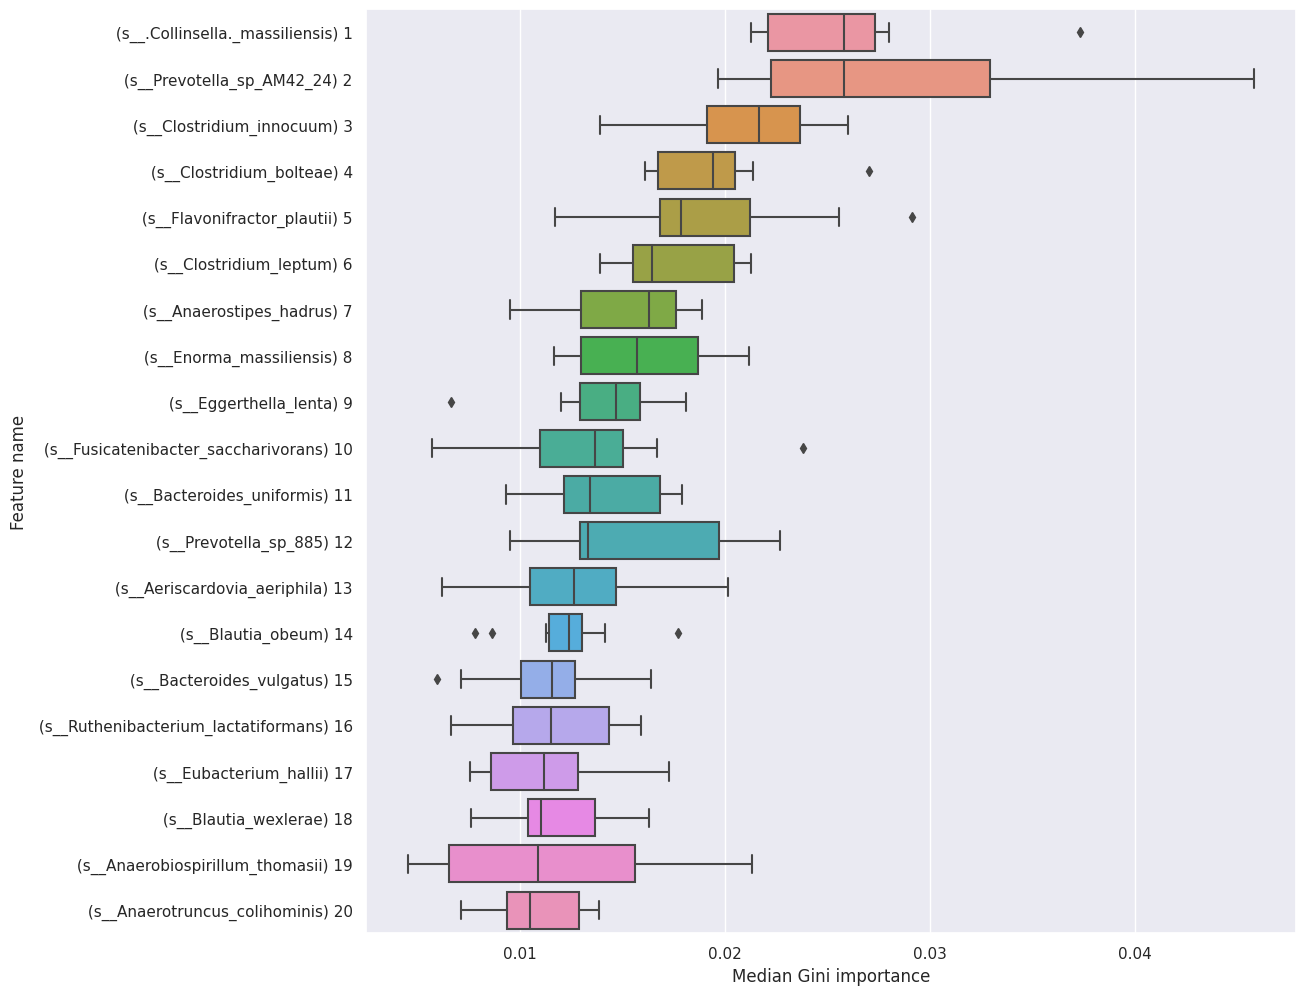

In [26]:
## ***** display results *****
evaluate_predictions(all_y_test, all_pred)

all_feature_importance_df = pd.read_csv(dataset_name+'_results_feature_importances.csv', index_col=0)
box_plot_df = display_top_features(all_feature_importance_df, 20)

sns.set(rc={'figure.figsize':(12,12)})
sns.boxplot(data=box_plot_df, x='Median Gini importance', y='Feature name')